# Data Retrieval for Inpatient Prospective Payment System (IPPS) 

The API information can be accessed through this [link](https://data.cms.gov/Medicare-Inpatient/Inpatient-Prospective-Payment-System-IPPS-Provider/97k6-zzx3)

<b>Question 1:</b> Can we infer meaningful correlations between the number of providers and the number of procedures done on average provider charge?

<b>Question 2:</b> Medicare and patients don't pay the full amount charged by the provider. Does this differ by state?

----
## Installation of Required Package(s)

In [144]:
# Installing the package sodapy, important for retrieval using the API's detailed method
import sys
!{sys.executable} -m pip install sodapy
import warnings
warnings.filterwarnings('ignore')

----
## Setup and Data Retrieval

### Configuring Matplotlib and Calling Required Packages

In [1]:
# Configuring matplotlib
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

# Required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata


### Data Retrieval and Data Frame Setup

In [2]:
# The API link
link = "https://data.cms.gov/resource/ehrv-m9r6.json"

# The app token and client
key = "oBbcgRhXZS4dqtTJVyz6zQujv"
client = Socrata("data.cms.gov", key)

# Retrieving all rows of data available returned as JSON from API 
# and converted to Python list of dictionaries by sodapy and then data frame
results_df = pd.DataFrame.from_records(client.get("ehrv-m9r6", limit=163065))

# Saving the data frame as .csv
results_df.to_csv("raw_ipps.csv")

# Checking the head of the data frame
results_df.head()

,average_covered_charges,average_medicare_payments,average_medicare_payments_2,drg_definition,hospital_referral_region_description,provider_city,provider_id,provider_name,provider_state,provider_street_address,provider_zip_code,total_discharges
0,32963.07,5777.24,4763.73,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Dothan,DOTHAN,10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,1108 ROSS CLARK CIRCLE,36301,91
1,15131.85,5787.57,4976.71,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Birmingham,BOAZ,10005,MARSHALL MEDICAL CENTER SOUTH,AL,2505 U S HIGHWAY 431 NORTH,35957,14
2,37560.37,5434.95,4453.79,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Birmingham,FLORENCE,10006,ELIZA COFFEE MEMORIAL HOSPITAL,AL,205 MARENGO STREET,35631,24
3,13998.28,5417.56,4129.16,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Birmingham,BIRMINGHAM,10011,ST VINCENT'S EAST,AL,50 MEDICAL PARK EAST DRIVE,35235,25
4,31633.27,5658.33,4851.44,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Birmingham,ALABASTER,10016,SHELBY BAPTIST MEDICAL CENTER,AL,1000 FIRST STREET NORTH,35007,18


---
## Data Exploration

### Creating a summary data frame grouped by state

In [3]:
# Convert some variables to numeric, because somehow it wasn't
results_df['average_covered_charges'] = pd.to_numeric(results_df['average_covered_charges'])
results_df['total_discharges'] = pd.to_numeric(results_df['total_discharges'])
results_df['average_medicare_payments'] = pd.to_numeric(results_df['average_medicare_payments'])

# Group results by "provider_state" and "drg_definition"
resultGB = results_df.groupby(["provider_state"]).agg({"average_covered_charges":["mean"],
                                                       "total_discharges":["sum"],
                                                       "provider_name":pd.Series.nunique,
                                                       "average_covered_charges":['mean'],
                                                       "average_medicare_payments":['mean']})
# multilevel indexing is scheiße
resultGB.columns.droplevel()
resultGB.columns = ["average_covered_charges", "total_discharges", "provider_count", 'average_medicare_payments']
resultGB.reset_index(inplace=True)
resultGB.to_csv('summary_ipps.csv')
resultGB.head()

,provider_state,average_covered_charges,total_discharges,provider_count,average_medicare_payments
0,AK,40348.743333,6142,9,14572.391732
1,AL,31316.462074,142704,93,7568.232149
2,AR,26174.526246,86769,45,8019.248805
3,AZ,41200.063020,104604,61,10154.528211
4,CA,67508.616536,474979,295,12629.668472



### Visualizing the number of providers in each state

In [25]:
resultGBpc = resultGB[["provider_state","provider_count"]].rename(columns={'provider_state':'State','provider_count':'Number of Providers'})
print('\033[1m''Top 10 Diagnosis(DRG) count by State')
resultGBpc.set_index(["State","Number of Providers"])

Top 10 Diagnosis(DRG) count by State


,
State,Number of Providers
TX,308
CA,295
FL,166
NY,161
PA,151
OH,131
IL,126
GA,106
TN,97


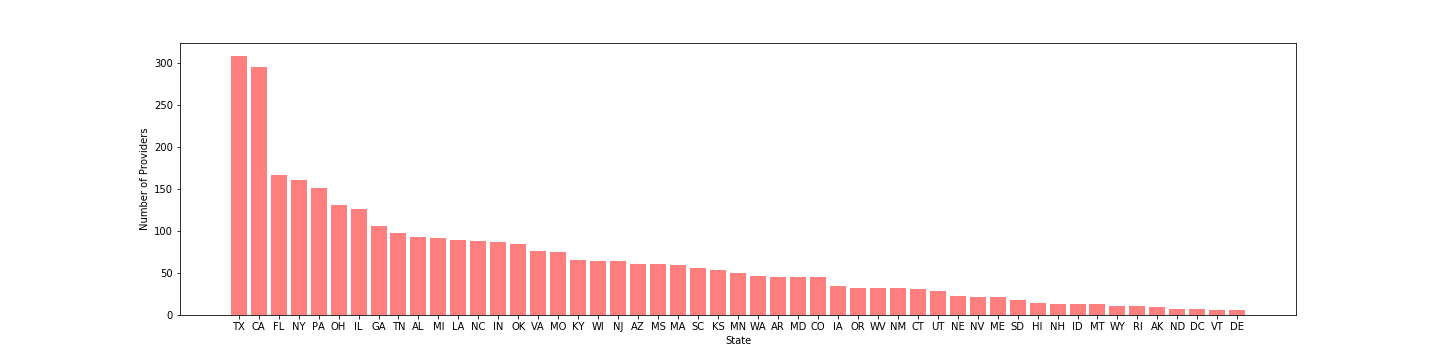

In [4]:
# Setting the figure size
plt.figure(figsize=(20,5))

# Sorting manually 
resultGB = resultGB.sort_values(by='provider_count', ascending=False).reset_index(drop=True)

# Drawing the plot
plt.bar(resultGB.index, resultGB['provider_count'] , alpha=0.5, color="red")
plt.xticks(resultGB.index, resultGB['provider_state'])
plt.ylabel('Number of Providers')
plt.xlabel('State')
plt.savefig('fig13.png')

### Visualizing the number of procedures done by each state

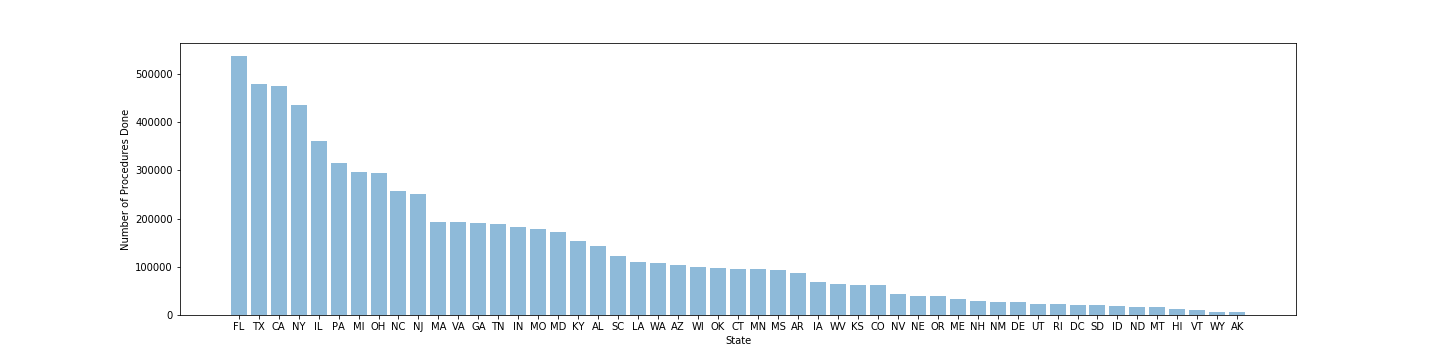

In [151]:
# Setting the figure size
plt.figure(figsize=(20,5))

# Sorting manually 
resultGB = resultGB.sort_values(by='total_discharges', ascending=False).reset_index(drop=True)

# Drawing the plot
plt.bar(resultGB.index, resultGB['total_discharges'], alpha=0.5)
plt.xticks(resultGB.index, resultGB['provider_state'])
plt.ylabel('Number of Procedures Done')
plt.xlabel('State')
plt.savefig('fig14.png')